### Import the necessary libraries

In [1]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import snowflake.connector

Define the following environment variable to connect to Snowflake:

```shell
export AIRFLOW_CONN_SNOWFLAKE_ADMIN='{
    "conn_type": "snowflake",
    "login": "<your-username>",
    "password": "<your-password>",
    "schema": "ORGANIZATION_USAGE",
    "extra": {
        "account": "<your-account>",
        "database": "SNOWFLAKE",
        "warehouse": "<your-warehouse>"
    }
}'
```

### Connect to Snowflake

In [2]:
airflow_con = json.loads(os.environ["AIRFLOW_CONN_SNOWFLAKE_ADMIN"])
snowflake_params = {
    "user": airflow_con["login"],
    "password": airflow_con["password"],
    "account": airflow_con["extra"]["account"],
    "region": airflow_con["extra"]["region"],
    "warehouse": airflow_con["extra"]["warehouse"],
    "database": airflow_con["extra"]["database"],
    "schema": airflow_con["schema"],
}
conn = snowflake.connector.connect(**snowflake_params)
cursor = conn.cursor()

### Perform EDA on the available Snowflake cost and usage tables

Snowflake pricing tier depends on a few different variables such as the cloud provider, region, plan type, services, and more. 
Snowflake costs are grouped into two distinct categories: **storage** and **compute.** 

- **Storage**: The monthly cost for storing data in Snowflake is based on a flat rate per terabyte (TB). Storage is calculated monthly based on the average number of on-disk bytes stored each day. The flat rate is determined based on the type of account (Capacity or On Demand) and the region (US / EU).

- **Compute:** Compute costs represent credits used for:

    - **Virtual** **Warehouse**: Credits are charged based on the number of virtual warehouses you use, how long they run, and their size.

    - **Cloud Services**: Cloud Services coordinate activities across Snowflake. Credits are consumed as Snowflake performs behind-the-scenes tasks such as authentication, infrastructure management, metadata management, query parsing and optimization, access control. Charged only if the daily consumption of cloud services resources exceeds 10% of the daily warehouse usage

    - **Serverless features**:  Services such as Snowpipe, Snowpipe streaming, Database Replication, Materialized Views, Automatic Clustering and Search Optimization also consume Snowflake credits when they are used. 

For all the details, you can read Snowflake’s documentation here: https://docs.snowflake.com/en/user-guide/cost-understanding-overall and here https://www.snowflake.com/pricing/pricing-guide/


#### Relevant Snowflake Tables
Pricing information can be fetched from the `USAGE_IN_CURRENCY_DAILY` and `WAREHOUSE_METERING_HISTORY` views in the ORGANIZATION_USAGE schema.

Astronomer uses the legacy usage view which does not provide meaningful compute usage breakdown. For that reason we need to manually aggregate the various usage types into the main cost categories: compute (and its subcategories), data transfer, storage and other. These categories follow Snowflake's definitions.

In [3]:
currency_query = """
SELECT ORGANIZATION_NAME, 
    CONTRACT_NUMBER, 
    ACCOUNT_NAME, 
    ACCOUNT_LOCATOR, 
    REGION, 
    SERVICE_LEVEL, 
    USAGE_DATE, 
    USAGE_TYPE, 
    CURRENCY, 
    BALANCE_SOURCE,
    CASE
      WHEN USAGE_TYPE LIKE '%storage'              THEN 'storage'
      WHEN USAGE_TYPE LIKE '%compute'              THEN 'compute'
      WHEN USAGE_TYPE LIKE '%cloud services'       THEN 'compute'  
      WHEN USAGE_TYPE LIKE '%automatic clustering' THEN 'compute' 
      WHEN USAGE_TYPE LIKE 'serverless tasks'      THEN 'compute' 
      WHEN USAGE_TYPE LIKE '%snowpipe%'            THEN 'compute' 
      WHEN USAGE_TYPE LIKE '%snowpark%'            THEN 'compute'
      WHEN USAGE_TYPE LIKE '%materialized views'   THEN 'compute'
      WHEN USAGE_TYPE LIKE '%data transfer'        THEN 'data transfer'
      WHEN USAGE_TYPE LIKE '%support%'             THEN 'other' 
      ELSE ''
    END AS RATING_TYPE,
    CASE
      WHEN USAGE_TYPE LIKE '%storage'              THEN 'storage'
      WHEN USAGE_TYPE LIKE '%compute'              THEN 'virtual warehouse'
      WHEN USAGE_TYPE LIKE '%cloud services'       THEN 'cloud services'  
      WHEN USAGE_TYPE LIKE '%automatic clustering' THEN 'serverless' 
      WHEN USAGE_TYPE LIKE 'serverless tasks'      THEN 'serverless' 
      WHEN USAGE_TYPE LIKE '%snowpipe%'            THEN 'serverless' 
      WHEN USAGE_TYPE LIKE '%snowpark%'            THEN 'serverless'
      WHEN USAGE_TYPE LIKE '%materialized views'   THEN 'serverless'
      WHEN USAGE_TYPE LIKE '%data transfer'        THEN 'data transfer'
      WHEN USAGE_TYPE LIKE '%support%'             THEN 'other' 
      ELSE ''
    END AS RESOURCE_TYPE,
    USAGE_IN_CURRENCY
FROM SNOWFLAKE.ORGANIZATION_USAGE.USAGE_IN_CURRENCY_DAILY
WHERE USAGE_DATE BETWEEN '2020-06-01' AND '2023-12-31'
AND ACCOUNT_NAME = 'GP21411' -- Astronomer's Account number
"""

cursor.execute(currency_query)
usage_df = cursor.fetch_pandas_all()

In [4]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

usage_df.groupby(
    by=[usage_df["USAGE_DATE"].map(lambda x: x.year), "RATING_TYPE", "RESOURCE_TYPE"]
).agg({"USAGE_IN_CURRENCY": "sum"}).unstack(level=[1, 2], fill_value=0)

USAGE_IN_CURRENCY                                       \
RATING_TYPE             compute                              storage   
RESOURCE_TYPE    cloud services serverless virtual warehouse storage   
USAGE_DATE                                                             
2020                       0.00       2.34           5618.72    5.14   
2021                       0.00       8.18          25077.89   50.86   
2022                    3308.59      10.27          40208.46  272.84   
2023                    8557.34       4.45          68552.67 1167.25   

                             
RATING_TYPE   data transfer  
RESOURCE_TYPE data transfer  
USAGE_DATE                   
2020                   0.00  
2021                   0.00  
2022                   0.00  
2023                   0.00

Key insights from this table:
- 99% of costs comes from compute
- 1% of costs from data storage
- Astronomer never incurred data transfer costs (no data egress).
- At 0.02% serverless costs are negligible
- Within the Compute category, 7.76% comes from Cloud Services, the rest comes from running Virtual Warehouses (91.24%)

In [5]:
fig = px.line(
    usage_df.sort_values(by="USAGE_DATE"),
    x="USAGE_DATE",
    y="USAGE_IN_CURRENCY",
    color="RESOURCE_TYPE",
    labels={"USAGE_IN_CURRENCY": "Usage in Currency", "USAGE_DATE": "Usage Date"},
    title="Usage in Currency Over Time",
)
fig.show()

 Looking at the usage by cost category, we find virtual warehouses and cloud services are the biggest expenses.
 We can also clearly visualize cyclical patterns and anomalies. 

Knowing all that, we can focus our attention to Virtual Warehouses. 

In [15]:
metering_query = """
SELECT ORGANIZATION_NAME,
ACCOUNT_NAME,
REGION,
ACCOUNT_LOCATOR,
SERVICE_TYPE,
TO_DATE(END_TIME) AS USAGE_DATE,
WAREHOUSE_NAME,
CREDITS_USED,
CREDITS_USED_COMPUTE,
CREDITS_USED_CLOUD_SERVICES
FROM SNOWFLAKE.ORGANIZATION_USAGE.WAREHOUSE_METERING_HISTORY
WHERE WAREHOUSE_ID > 0  -- Skip pseudo-VWs such as "CLOUD_SERVICES_ONLY"
AND USAGE_DATE BETWEEN '2023-01-01' AND '2023-12-31' -- Only 1 year is available
AND ACCOUNT_NAME = 'GP21411' -- Astronomer's Account number
"""
cursor.execute(metering_query)
metering_df = cursor.fetch_pandas_all()

In [16]:
metering_df.groupby(
    by=[metering_df["USAGE_DATE"].map(lambda x: x.year), "WAREHOUSE_NAME"]
).agg({"CREDITS_USED": "sum"}).unstack(level=[1], fill_value=0)

CREDITS_USED                                               \
WAREHOUSE_NAME    BIG_ROBOT FIVETRAN  HUMANS LOADING   ROBOTS ROBOTS_DEV   
USAGE_DATE                                                                 
2023                2845.93  1906.19 1764.31  845.80 11780.39       0.37   

                                                                       
WAREHOUSE_NAME SECURITY SEGMENT_DEV SEGMENT_PROD   SIGMA TRANSFORMING  
USAGE_DATE                                                             
2023               0.30      757.06      1431.60 5853.97     12044.09

In [17]:
# We fill in the missing dates in the dataframe with zeros
warehouses = metering_df["WAREHOUSE_NAME"].dropna().unique()
dates = pd.date_range(
    metering_df["USAGE_DATE"].min(), metering_df["USAGE_DATE"].max(), freq="D"
)
multi_index = pd.MultiIndex.from_product(
    [warehouses, dates], names=["WAREHOUSE_NAME", "USAGE_DATE"]
)
metering_df = (
    metering_df.groupby(["WAREHOUSE_NAME", "USAGE_DATE"])
    .agg({"CREDITS_USED": "sum"})
    .reindex(multi_index, fill_value=0)
    .reset_index()
)

fig = px.line(
    metering_df.sort_values(by="USAGE_DATE"),
    x="USAGE_DATE",
    y="CREDITS_USED",
    color="WAREHOUSE_NAME",
    labels={"CREDITS_USED": "Credit used", "USAGE_DATE": "Usage Date"},
    title="Credit used by Warehouses Over Time",
)
fig.show()

### Weekly Metering

So far we have only looked at the daily usage for each warehouse. As we can see in the charts, anomalies sometimes persist for more than a day.
Let's aggregate the metering data weekly.

In [18]:
weekly_metering_df = metering_df[["USAGE_DATE", "WAREHOUSE_NAME", "CREDITS_USED"]]

weekly_metering_df = (
    weekly_metering_df.groupby(
        ["WAREHOUSE_NAME", pd.Grouper(key="USAGE_DATE", freq="W")]
    )
    .agg({"CREDITS_USED": "sum"})
    .reset_index()
)

fig = px.line(
    weekly_metering_df.sort_values(by="USAGE_DATE"),
    x="USAGE_DATE",
    y="CREDITS_USED",
    color="WAREHOUSE_NAME",
    labels={"CREDITS_USED": "Credit used", "USAGE_DATE": "Usage Date"},
    title="Credit used by Warehouses Over Time",
)
fig.show()

### Breakdown by Warehouse

Let's look at individual wharehouse to have a better idea of the anomalies

In [19]:
fig = px.line(
    metering_df.sort_values(by="USAGE_DATE"),
    x="USAGE_DATE",
    y="CREDITS_USED",
    color="WAREHOUSE_NAME",
    facet_row="WAREHOUSE_NAME",
    labels={"CREDITS_USED": "Credit used", "USAGE_DATE": "Usage Date"},
    title="Credit used by Warehouses Over Time",
    height=2000,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None)
fig.update_layout(showlegend=False)
fig.show()

Looking at the above chart, we can see some trends and recurring patterns in Warehouse credit usage.

Let's apply seasonal_decompose to see if we can isolate seasonality and trend. Outliers will show up in the residuals.

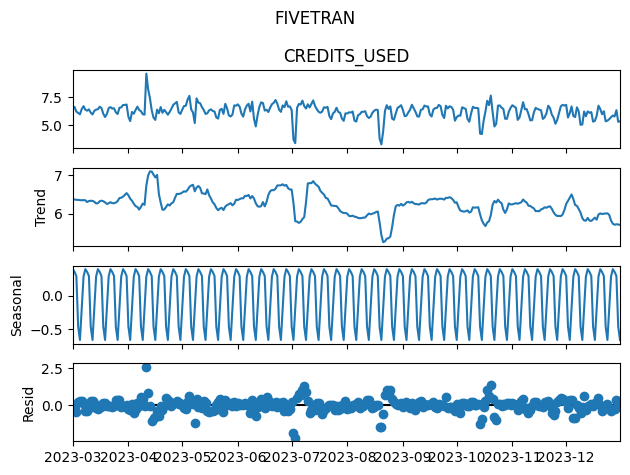

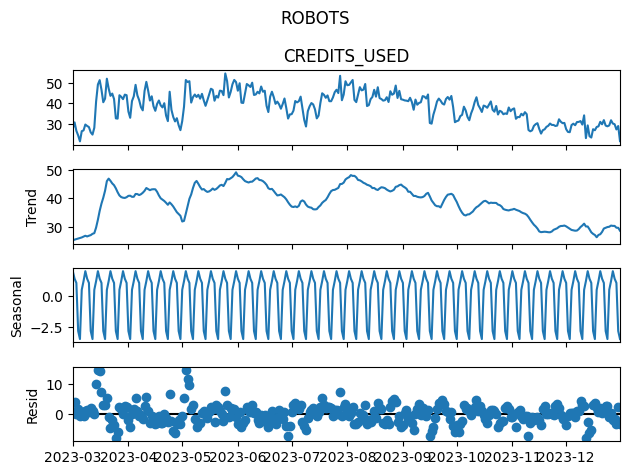

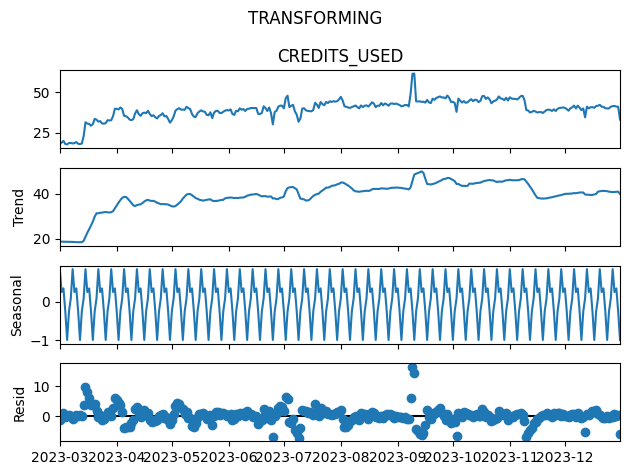

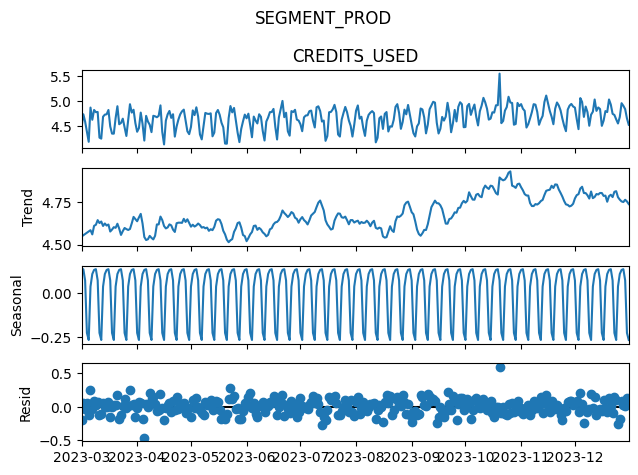

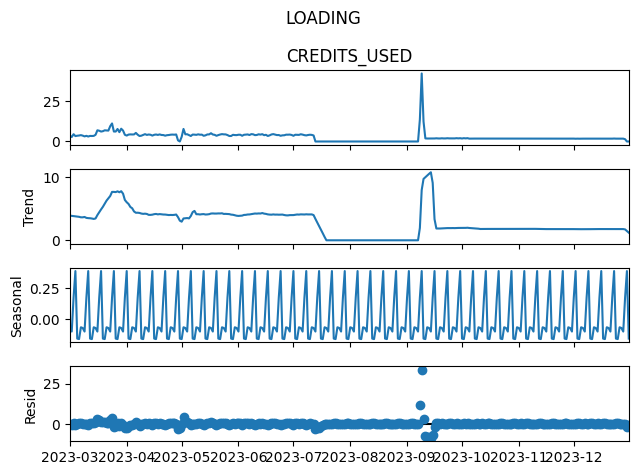

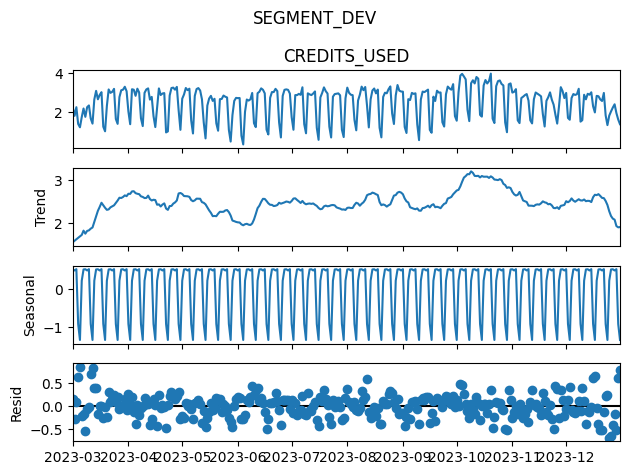

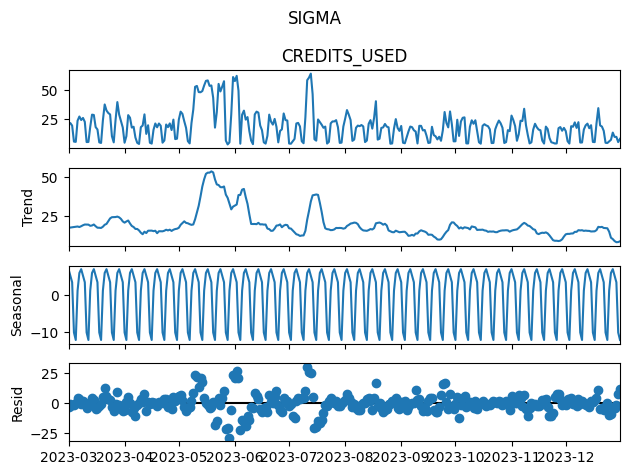

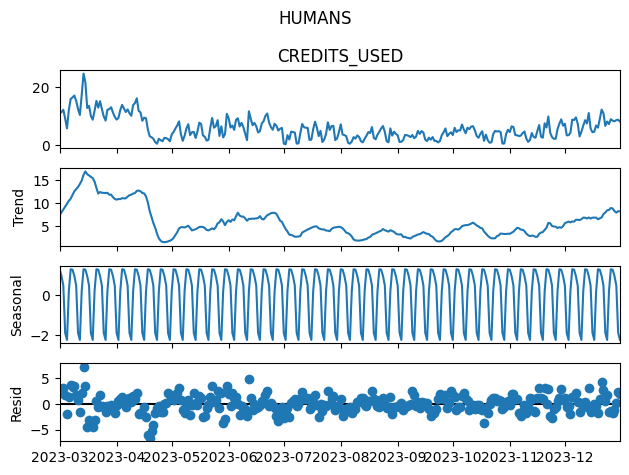

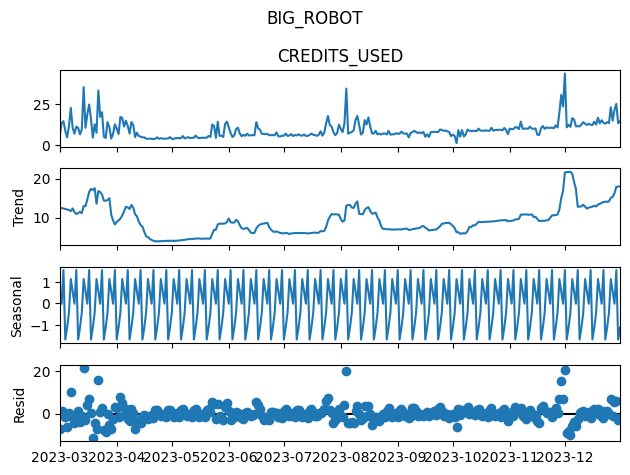

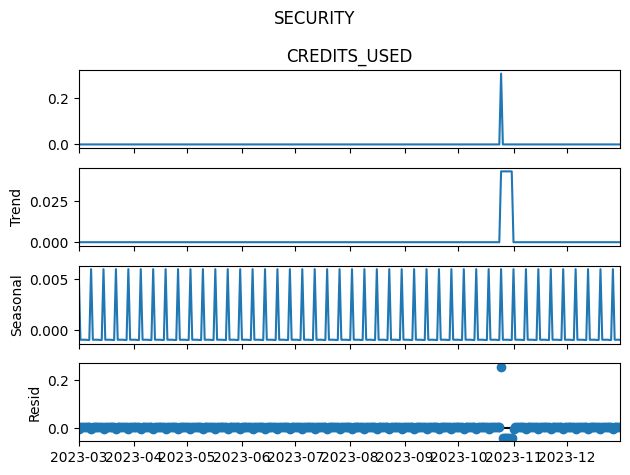

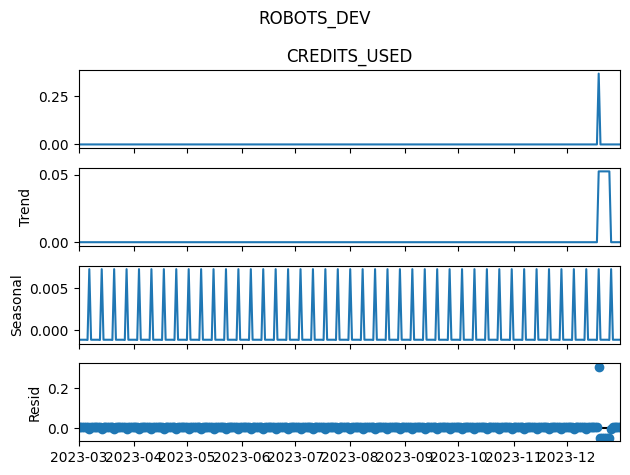

In [20]:
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose

warehouses = metering_df["WAREHOUSE_NAME"].unique()
warehouses

residuals = {}

for warehouse in warehouses:
    df = metering_df[metering_df["WAREHOUSE_NAME"] == warehouse]
    df.set_index("USAGE_DATE", inplace=True)
    compute_stl = seasonal_decompose(
        x=df["CREDITS_USED"],
        model="additive",
        extrapolate_trend="freq",
        two_sided=False,
    )
    compute_stationary = compute_stl.resid.values.reshape(-1, 1)

    # Save the residuals to use for anomaly detection
    residuals[warehouse] = compute_stationary

    fig = compute_stl.plot()
    plt.suptitle(warehouse)
    plt.tight_layout()
    plt.show()

In [28]:
for warehouse, compute_stationary in residuals.items():
    compute_model = IsolationForest().fit(compute_stationary)

    warehouse_filter = metering_df["WAREHOUSE_NAME"] == warehouse
    metering_df.loc[
        warehouse_filter, "compute_scores"
    ] = compute_model.decision_function(compute_stationary)

    mean_scores = metering_df.loc[warehouse_filter, "compute_scores"].mean()
    std_scores = metering_df.loc[warehouse_filter, "compute_scores"].std()
    compute_threshold = mean_scores - (2 * std_scores)

    metering_df.loc[warehouse_filter, "compute_threshold"] = compute_threshold
metering_df

WAREHOUSE_NAME USAGE_DATE  CREDITS_USED  compute_scores  \
0          FIVETRAN 2023-03-01          6.41            0.06   
1          FIVETRAN 2023-03-02          6.62            0.08   
2          FIVETRAN 2023-03-03          6.21            0.02   
3          FIVETRAN 2023-03-04          6.09            0.11   
4          FIVETRAN 2023-03-05          5.98            0.07   
...             ...        ...           ...             ...   
3361     ROBOTS_DEV 2023-12-27          0.00            0.09   
3362     ROBOTS_DEV 2023-12-28          0.00            0.09   
3363     ROBOTS_DEV 2023-12-29          0.00            0.09   
3364     ROBOTS_DEV 2023-12-30          0.00            0.09   
3365     ROBOTS_DEV 2023-12-31          0.00            0.09   

      compute_threshold  
0                 -0.08  
1                 -0.08  
2                 -0.08  
3                 -0.08  
4                 -0.08  
...                 ...  
3361              -0.09  
3362              -0.09  
3363              -0.09  
3364              -0.09  
3365              -0.09  

[3366 rows x 5 columns]

In [33]:
anomalies = metering_df.loc[
    (metering_df["compute_scores"] <= metering_df["compute_threshold"])
    & (metering_df["CREDITS_USED"] > metering_df["CREDITS_USED"].mean())
]

# Plot the line chart
fig = px.line(
    metering_df,
    x="USAGE_DATE",
    y="CREDITS_USED",
    color="WAREHOUSE_NAME",
    title="Credits Used Over Time",
    labels={"CREDITS_USED": "Credits Used", "Date_Column": "Date"},
)

# Highlight data points above the compute_threshold in a different color
if not anomalies.empty:
    scatter_trace = px.scatter(
        anomalies, x="USAGE_DATE", y="CREDITS_USED", color_discrete_sequence=["black"]
    )
    fig.add_trace(scatter_trace.data[0])
# Show the plot
fig.show()

In [ ]:
anomalies

# Detecting Drift

Evidently Reports are great to quickly test for Data Drift.

In our case, we will also use Tests to check drift for each warehouse and trigger retraining of the model when drift is detected. 

In [ ]:
from evidently.report import Report
from evidently.metrics import DataDriftTable

from evidently.test_suite import TestSuite
from evidently.tests import TestAllFeaturesValueDrift

In [ ]:
df = metering_df[["USAGE_DATE", "WAREHOUSE_NAME", "CREDITS_USED"]].sort_values(
    by="USAGE_DATE"
)
df = df.pivot(index="USAGE_DATE", columns="WAREHOUSE_NAME", values="CREDITS_USED")
df.reset_index(inplace=True)

most_recent_week_start = df["USAGE_DATE"].max() - pd.DateOffset(days=7)

reference_df = df[df["USAGE_DATE"] < most_recent_week_start]
current_df = df[df["USAGE_DATE"] >= most_recent_week_start]

In [ ]:
data_drift_report = Report(
    metrics=[
        DataDriftTable(stattest="ks"),
    ]
)

data_drift_report.run(current_data=current_df, reference_data=reference_df)
data_drift_report.show(mode="inline")

Reports help visually explore the data or model quality or share results with the team. 
However, it is less convenient if you want to run your checks automatically and only react to meaningful issues

To integrate Evidently checks in the prediction pipeline, you can use the Test Suites functionality. They are also better suited to handle large datasets.

Our ultimate goal is to retrain models when drift occurs. 

In [ ]:
suite = TestSuite(tests=[TestAllFeaturesValueDrift(stattest="ks")])
suite.run(reference_data=reference_df, current_data=current_df)
suite.show(mode="inline")

We can then use the test results as a dictionnary to automate retraining of the drifted models later on

In [ ]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(suite.as_dict())

In [ ]:
results = pd.DataFrame([x.get("parameters") for x in suite.as_dict().get("tests")])

In [ ]:
results